In [17]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import graph_prep

## Loading Data, Generate Graph & Embeddings

In [18]:
data = ['preprocessed_34_10.tsv', 'preprocessed_42_10.tsv']

###### edit here to change dataset ######
dat_idx = 0 # choose from [0,1]
#########################################

file_path = "../data/" + data[dat_idx]
df = pd.read_csv(file_path, sep='\t', index_col=0)

In [19]:
G = graph_prep.nx_drug_gene_bipartite(df)

In [20]:
embedding_methods = ['node2vec', 'deepwalk']

###### edit here to change the node embedding method ######
emd_idx = 1 # choose from [0,1]
#########################################

if embedding_methods[emd_idx] == 'node2vec':
    node_embeddings = graph_prep.node2vec_embedding(G)
elif embedding_methods[emd_idx] == 'deepwalk':
    node_embeddings = graph_prep.deepwalk_embedding(G)
else:
    raise ValueError("Invalid embedding methods.")

Computing transition probabilities:   0%|          | 0/1637 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 75/75 [00:13<00:00,  5.36it/s]

## Model Functions & Configurations

In [21]:
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from scipy.stats import loguniform, randint
import matplotlib.pyplot as plt

In [22]:
# Initialize dictionaries to store metrics and models
metrics = {}
models = {}
roc_data = {}
prc_data = {}

In [23]:
# Hyperparameter distributions
lr_param_dist = {'C': loguniform(0.001, 1000)}
xgb_param_dist = {
    'learning_rate': loguniform(0.01, 0.2),
    'n_estimators': randint(50, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': loguniform(0.001, 1),
    'subsample': loguniform(0.5, 1),
    'colsample_bytree': loguniform(0.5, 1)
}
svm_param_dist = {'C': loguniform(0.001, 1000), 'gamma': loguniform(0.001, 1)}

In [24]:
from sklearn.model_selection import KFold
import random

learning_rate_range = np.logspace(-4, -1, 10)
epochs_range = range(50, 300, 50)


def tune_nn_hyperparameters(model_class, X, y, learning_rate_range, epochs_range, n_splits=5, n_iter=100):
    best_score = 0
    best_params = {'learning_rate': None, 'epochs': None}
    kfold = KFold(n_splits=n_splits, shuffle=True)

    for _ in range(n_iter):
        lr = random.choice(learning_rate_range)
        epochs = random.choice(epochs_range)

        scores = []
        for train_index, val_index in kfold.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = model_class(X_train.shape[1])
            metrics, _, _ = train_evaluate_nn(model, X_train, X_val, y_train, y_val, epochs=epochs, learning_rate=lr)
            score = metrics['AUC-ROC']  # Choose your metric here
            scores.append(score)

        average_score = np.mean(scores)
        if average_score > best_score:
            best_score = average_score
            best_params['learning_rate'] = lr
            best_params['epochs'] = epochs

    return best_params, best_score

In [25]:
# Softmax Layer Neural Network
class SoftmaxNN(nn.Module):
    def __init__(self, input_size):
        super(SoftmaxNN, self).__init__()
        self.fc = nn.Linear(input_size, 2)

    def forward(self, x):
        return nn.functional.softmax(self.fc(x), dim=1)

In [26]:
# Function for hyperparameter tuning
def tune_hyperparameters(clf, param_dist, X_train, y_train):
    #random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

In [27]:
# Function for training and evaluating the model
def train_evaluate_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_probs),
        'AUC-PRC': auc(recall, precision)
    }

    roc_data = roc_curve(y_test, y_probs)
    prc_data = precision_recall_curve(y_test, y_probs)

    print("Metrics: ", end='')
    print(metrics)
    # print("AUC-ROC: ")
    # print(roc_data)
    # print("AUC-PRC: ")
    # print(prc_data)

    return metrics, roc_data, prc_data


def train_evaluate_nn(model, X_train, X_test, y_train, y_test, epochs=200, learning_rate=0.01):
    # Convert data to PyTorch tensors
    X_train_torch = torch.tensor(X_train.astype(np.float32))
    X_test_torch = torch.tensor(X_test.astype(np.float32))
    y_train_torch = torch.tensor(y_train.astype(np.int64))
    y_test_torch = torch.tensor(y_test.astype(np.int64))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_probs_torch = model(X_test_torch)
        y_probs = y_probs_torch.numpy()[:, 1]  # Probabilities for the positive class
        y_pred = np.argmax(y_probs_torch.numpy(), axis=1)

    # Check if y_probs is valid
    if not (0 <= y_probs).all() and (y_probs <= 1).all():
        raise ValueError("y_probs contains values outside the range [0, 1]")

    # Check if y_test is in the correct format
    if not set(np.unique(y_test)).issubset({0, 1}):
        raise ValueError("y_test should only contain 0 and 1")

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    try:
        roc_data = roc_curve(y_test, y_probs)
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        metrics['AUC-ROC'] = roc_auc_score(y_test, y_probs)
        metrics['AUC-PRC'] = auc(recall, precision)
        prc_data = (precision, recall, _)
        #print(metrics)
    except ValueError as e:
        print(f"Error calculating ROC or PRC: {e}")
        roc_data = ([], [], [])
        prc_data = ([], [], [])

    return metrics, roc_data, prc_data

In [28]:
def plot_metrics(roc_data, prc_data, save_fig=False, filename='model_evaluation_plots.png'):
    # Unpack ROC data
    fpr, tpr, _ = roc_data
    # Unpack Precision-Recall data
    precision, recall, _ = prc_data

    # Create subplots
    fig, (ax_roc, ax_prc) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC Curve
    ax_roc.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curve')
    ax_roc.legend(loc="lower right")

    # Plot Precision-Recall Curve
    ax_prc.plot(recall, precision, color='green', lw=2, label='PR curve')
    ax_prc.set_xlim([0.0, 1.0])
    ax_prc.set_ylim([0.0, 1.05])
    ax_prc.set_xlabel('Recall')
    ax_prc.set_ylabel('Precision')
    ax_prc.set_title('Precision-Recall Curve')
    ax_prc.legend(loc="lower left")

    # Show the plots
    plt.tight_layout()

    # Save the figure
    if save_fig:
        plt.savefig(filename, dpi=300)

    plt.show()

## Sampling, Train-Test-Split, Dimensionality Reduction, Classification

In [29]:
import warnings
warnings.filterwarnings('ignore')

---------------------------------------------------------------------------
softmax
----------------------------
Sampling Method:  random_under
PCA applied. PCA Explained Variance:  0.8974226667778566
Stratified Train-Test Split:  True


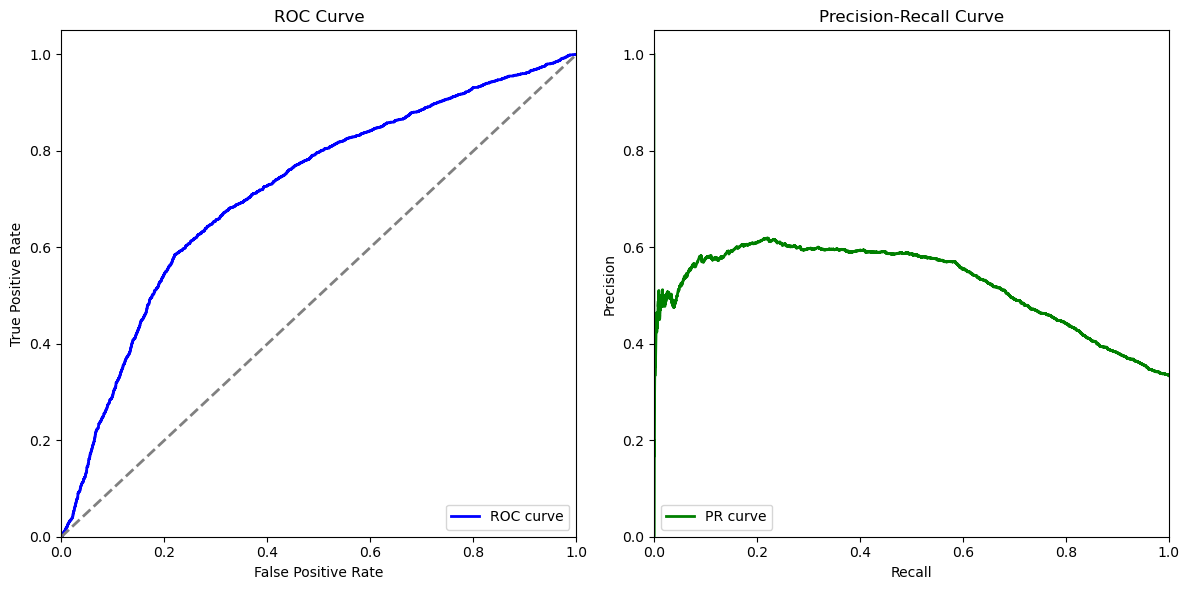

----------------------------
Sampling Method:  random_under
PCA not applied.
Stratified Train-Test Split:  True


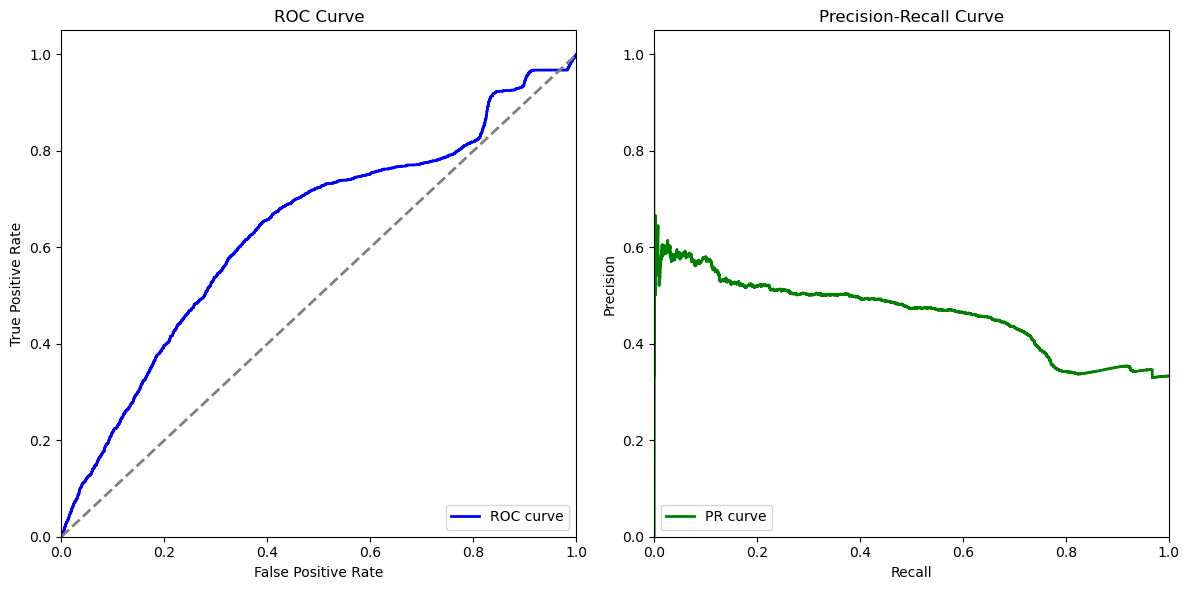

----------------------------
Sampling Method:  random_under
PCA applied. PCA Explained Variance:  0.8974226667778566
Stratified Train-Test Split:  False


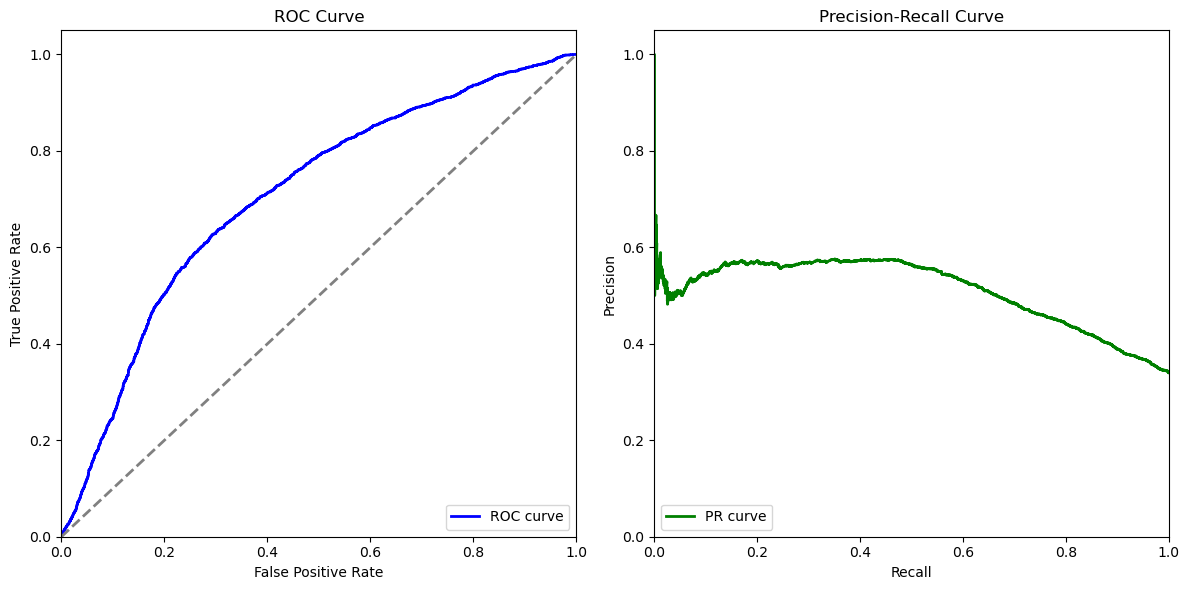

----------------------------
Sampling Method:  random_under
PCA not applied.
Stratified Train-Test Split:  False


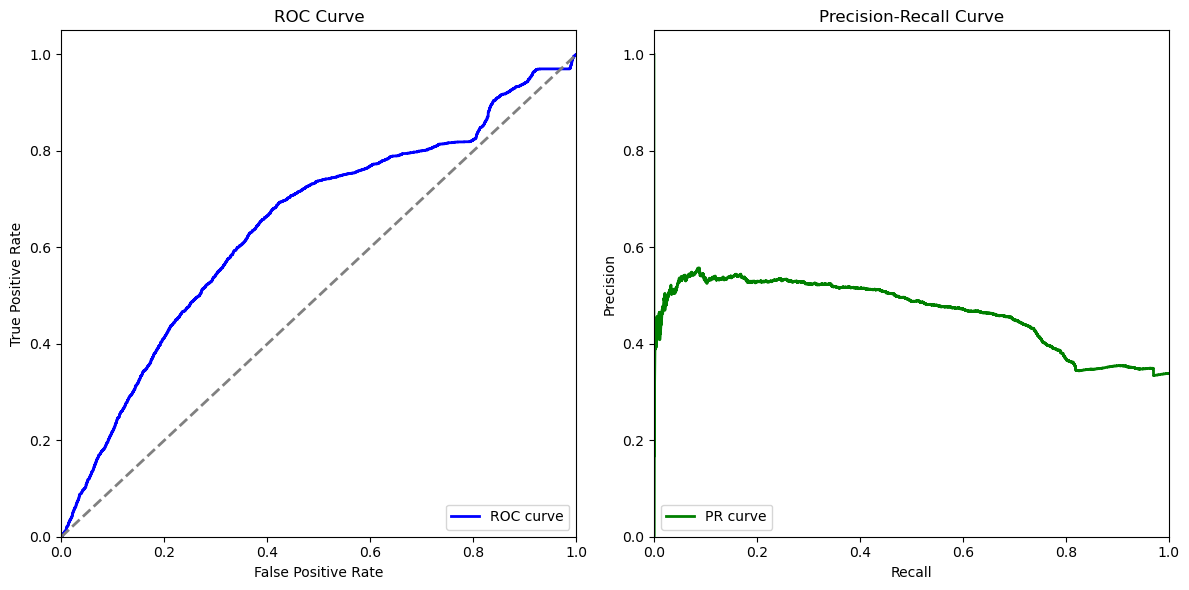

----------------------------
Sampling Method:  distance_under
PCA applied. PCA Explained Variance:  0.9187540517887101
Stratified Train-Test Split:  True


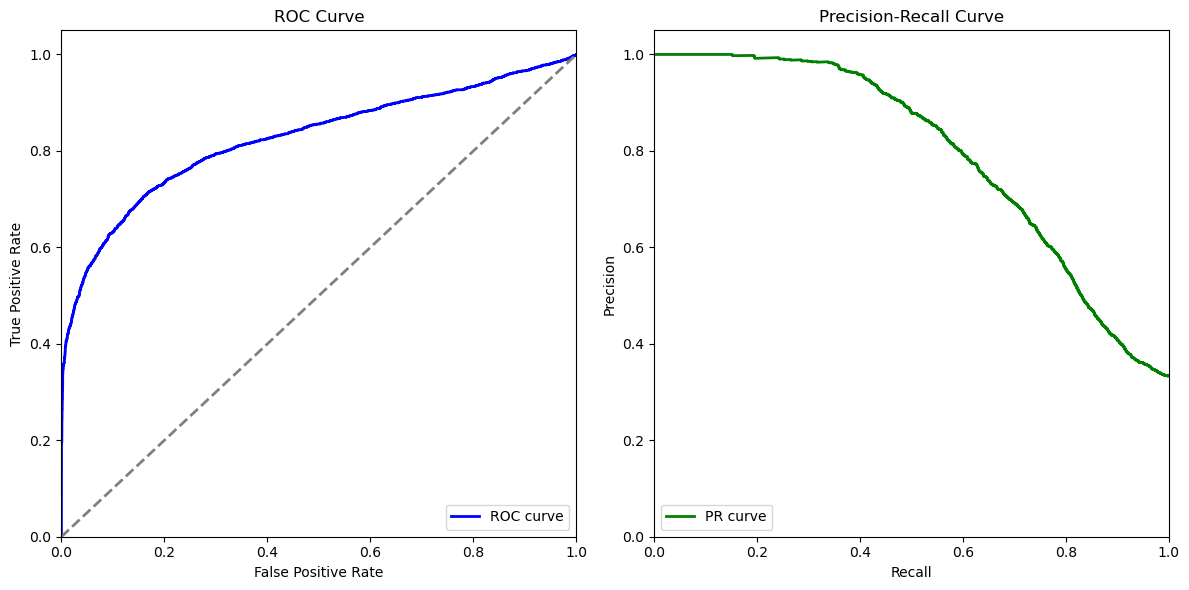

----------------------------
Sampling Method:  distance_under
PCA not applied.
Stratified Train-Test Split:  True


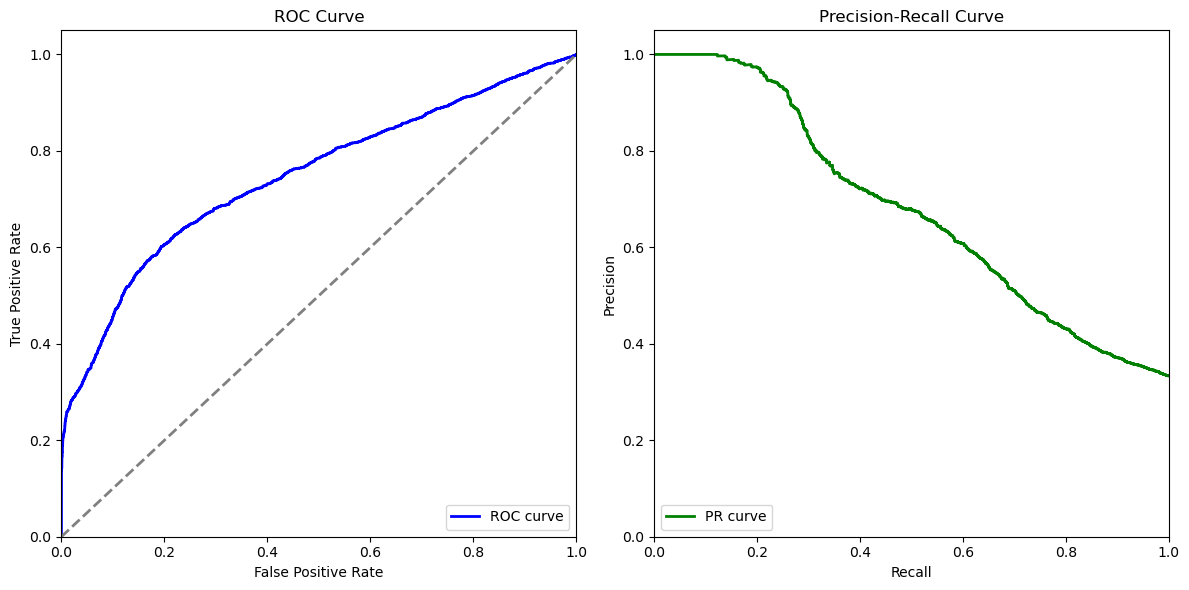

----------------------------
Sampling Method:  distance_under
PCA applied. PCA Explained Variance:  0.9189294064417481
Stratified Train-Test Split:  False


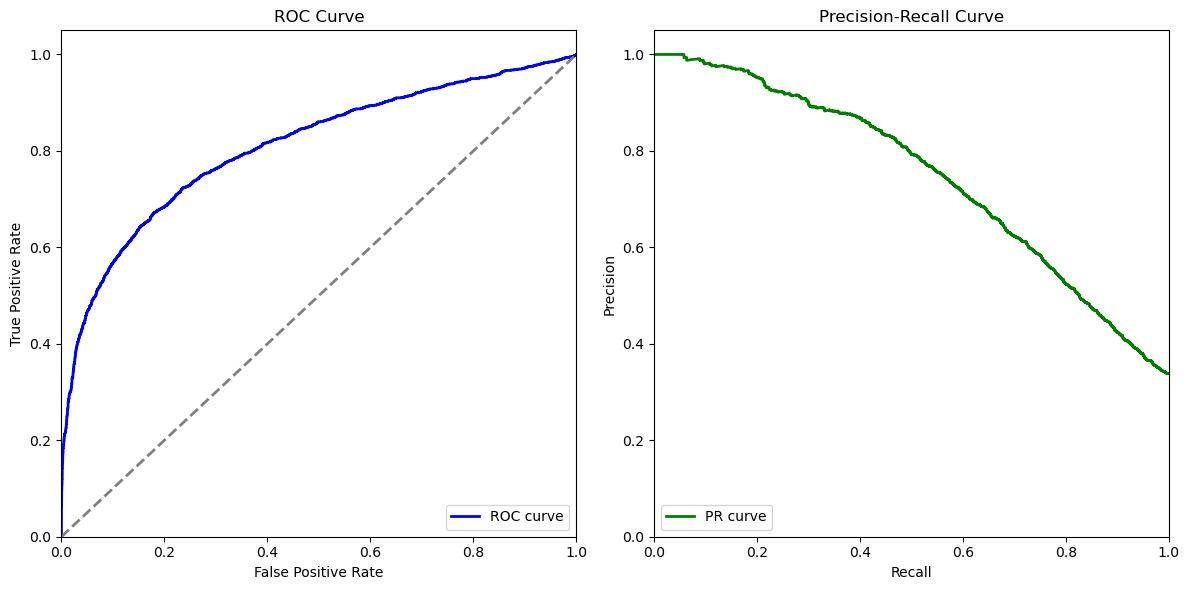

----------------------------
Sampling Method:  distance_under
PCA not applied.
Stratified Train-Test Split:  False


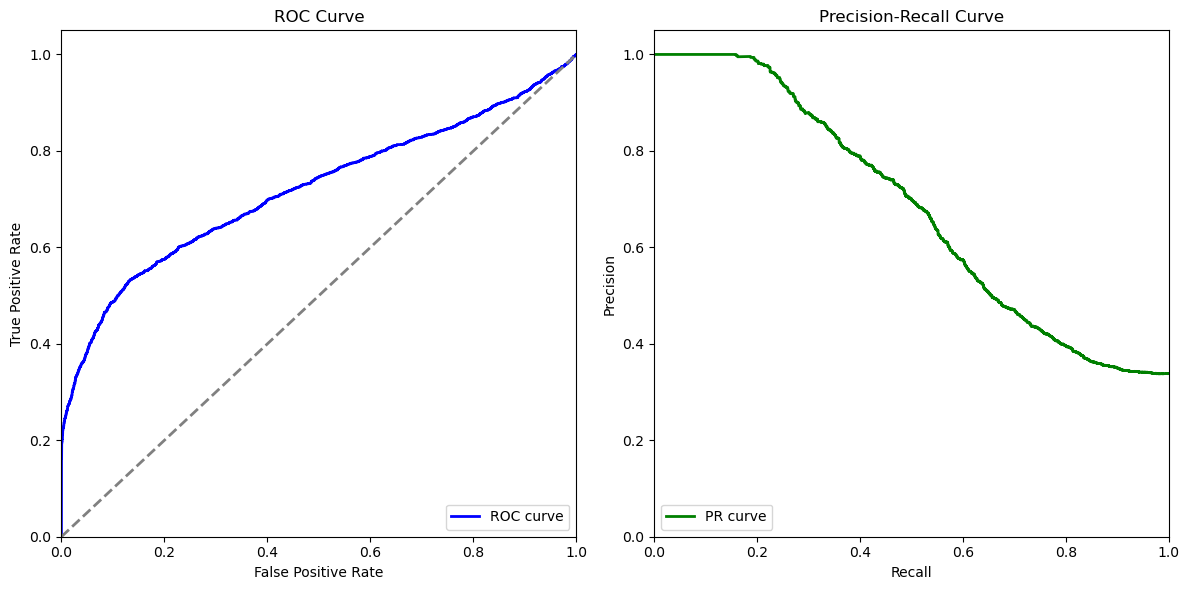

In [31]:
classification_models = ['lr', 'svm', 'xgb', 'softmax']

###### edit here to change classification model ######
clf_idx = 3 # choose from [0,3]
#########################################


print("---------------------------------------------------------------------------")
print(classification_models[clf_idx])
for sampling in ['random_under', 'distance_under']:
#for sampling in ['distance_under']:
    for if_stratified in [True, False]:
    #for if_stratified in [False]:
        for if_PCA in [True, False]:
        #for if_PCA in [True]:


            print("----------------------------")

            # sampling
            sampled_edges, sampled_labels = graph_prep.negative_sampling(df, node_embeddings, method=sampling)
            print("Sampling Method: ", sampling)

            if if_PCA:
                # dimensionality reduction
                print("PCA applied. ", end='')
                sampled_edges = graph_prep.perform_pca(sampled_edges)
            else:
                print("PCA not applied.")

            # train-test split
            X_train, X_test, y_train, y_test = graph_prep.edge_train_test_split(sampled_edges, sampled_labels, stratified=if_stratified)
            print("Stratified Train-Test Split: ", if_stratified)

            # LR
            if classification_models[clf_idx] == 'lr':
                lr_clf = tune_hyperparameters(LogisticRegression(max_iter=100000), lr_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(lr_clf, X_train, X_test, y_train, y_test)


            # SVM
            elif classification_models[clf_idx] == 'svm':
                svm_clf = tune_hyperparameters(SVC(probability=True), svm_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(svm_clf, X_train, X_test, y_train, y_test)

            # XGB
            elif classification_models[clf_idx] == 'xgb':
                xgb_clf = tune_hyperparameters(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(xgb_clf, X_train, X_test, y_train, y_test)

            # Softmax
            elif classification_models[clf_idx] == 'softmax':
                best_params, best_score = tune_nn_hyperparameters(SoftmaxNN, X_train, y_train, learning_rate_range, epochs_range)
                nn_model = SoftmaxNN(X_train.shape[1])
                best_learning_rate = best_params['learning_rate']
                best_epochs = best_params['epochs']
                metrics, roc_data, prc_data = train_evaluate_nn(nn_model, X_train, X_test, y_train, y_test, epochs=best_epochs, learning_rate=best_learning_rate)

            else:
                raise ValueError("Invalid value for classification model.")


            ##### Directory for saving results ######
            #save_dir = '../res/'+ classification_models[clf_idx]
            save_dir = '../res/'+ classification_models[clf_idx] + '/' + embedding_methods[emd_idx]
            os.makedirs(save_dir, exist_ok=True)
            # Convert the metrics to a pandas DataFrame
            metrics_df = pd.DataFrame([metrics])
            roc_df = pd.DataFrame ({'fpr':roc_data[0], 'tpr':roc_data[1], '_':roc_data[2]})
            prc_df = pd.DataFrame({'precision':prc_data[0],'recall':prc_data[1],'_':np.append(prc_data[2],0)})

            #save the results
            stratified = "stratified" if if_stratified else "unstratified"
            pca = "pca" if if_PCA else ""
            save_name = save_dir + '/' + sampling +'_' + pca + '_' + stratified
            #export to csv
            metrics_df.to_csv(save_name+'.csv', index=False)
            roc_df.to_csv(save_name+'auc_roc.csv', index=False)
            prc_df.to_csv(save_name+'auc_prc.csv', index=False)

            # pickle.dump(models[classification_models[clf_idx]], open(f'{save_dir}/{classification_models[clf_idx]}_model.pkl', 'wb'))
            # pd.DataFrame([metrics[classification_models[clf_idx]]]).to_csv(f'{save_dir}/{classification_models[clf_idx]}_metrics.csv', index=False)
            plot_metrics(roc_data, prc_data, save_fig=True, filename=save_name)
            #########################################